28706508 Malek Bouzarkouna
3521887 Sevag Baboyan

# TME 5.1 : Deep Learning - programmer et entraîner un neurone artificiel


## Recherche de pattern (motifs) en utilisant de réseau de neurones

Nous allons reprogrammer un neurone artificiel et l'algorithme de back propagation pour reconnaître un motif particulier 
Pour comprendre le principe nous utiliserons des données simulées générées à partir de matrice de fréquences d'un motif d'intérêt,
étiquetées avec 1 (les séquences ne contiennent le motif) et des séquences aléatoires, étiquetées avec 0 (les séquences ne contiennent pas le motif).
Notre objectif est de construire un classifieur capable de prédire si une séquence particulière contient le motif d'intérêt.

## 1. Préparation de données
1.1 Nous allons d'abord générer des données artificielles, un jeu de données de séquences ayant le motif (positives = label 1) et un jeu de données de séquences aléatoires (négatives = label 0). Pour générer les séquences positives, utilisez la matrice de fréquence du motif AGTATAG.Pour générer les séquences négatives une distribution uniforme ou les nucléotides sont choisis aléatoirement.Générer 100 séquences positives et 100 séquences négatives. 

In [2085]:
import numpy as np
import matplotlib.pyplot as plt
import random
import array
import math

motif_length = 7
num_sample = 100

MotifConsensus = "AGTATAG"

nuc = ['A','C','T','G']

def generatePWM(MF):
    t = len(MF)
    n = len(MF[0])
    
    PWM = np.zeros((t,n))
    for i in range(n):
        s = 0
        for j in range(t):
            s += MF[j][i]
        for j in range(t):
            PWM[j][i] = MF[j][i] / s
    return PWM
            
    
freq = np.array([
  [1000,  12,   3,  1000,   5,   1000,   1],
  [10,    8,   3,   3,   0,    10,   1],
  [4,   1000,   2,   7,   5,    13,   1000],
  [6,    10,  1000,   5,   1000,   6,   1]])

#Transformer freq en matrice de poids position
#PWM = generatePWM(freq)
PWM = freq / freq.sum(axis = 0)
print(PWM)


[[9.80392157e-01 1.16504854e-02 2.97619048e-03 9.85221675e-01
  4.95049505e-03 9.71817298e-01 9.97008973e-04]
 [9.80392157e-03 7.76699029e-03 2.97619048e-03 2.95566502e-03
  0.00000000e+00 9.71817298e-03 9.97008973e-04]
 [3.92156863e-03 9.70873786e-01 1.98412698e-03 6.89655172e-03
  4.95049505e-03 1.26336249e-02 9.97008973e-01]
 [5.88235294e-03 9.70873786e-03 9.92063492e-01 4.92610837e-03
  9.90099010e-01 5.83090379e-03 9.97008973e-04]]


In [2086]:
def createArtSequences(freq, num_sample=100):
    """
    Genere deux jeux de sequences: positives (ayant le motif) et negatives (aleatoires)
    entrée PWM : matrice de poids position qui represent le motif d'interet
    entrée num_sample : int, nombre d'echantillons
    sortie pos : list contenant les sequences positives
    sortie neg : list contenant les sequences negatives
    """
    pos = []
    neg = []
    j = 0
    for i in range(num_sample):
        tmp = []
        for j in range(len(freq[0])):
            posl = PWM[:,j].tolist()
            #print (posl)
            nucleotide = np.random.choice(nuc, 1, p = posl)
            #print (nucleotide)
            tmp.append("".join(nucleotide))
        j = 0
        pos.append("".join(tmp))
        neg.append("".join(np.random.choice(nuc, 7)))

    return pos, neg

num_sample =100
pos, neg  = createArtSequences(freq, num_sample)
print(pos)
print("\n\n")
print(neg)

['ATGAGAT', 'ATGAGAT', 'ATGGGAT', 'ATGAGAT', 'ATGAGCT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'AGTAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGCGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ACGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAC', 'ATGAGCT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'GTGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ACGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'ATGAGAT', 'CTGAGAT', 'CTGAGAT'

1.2 Générer le vecteur y contenant les labels de séquences générer à la question précédente, séquences positives = label 1, et négatives = label 0. Pour simplifier les prochain calculs y doit être un numpy array de dimension (num_sample*2, 1)

In [2087]:
y = np.zeros(200)
y[:99] =1
y = y.reshape(y.shape[0],1)
print(y)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

1.3 Nous allons créer notre matrice X contenant deux features, pour simplifier x1 sera le nombre de AG et x2 le nombre de TA. Par exemple, pour la séquence AGAGTAG, x1 = 3 et x2=1

[[1. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [2. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 0.]


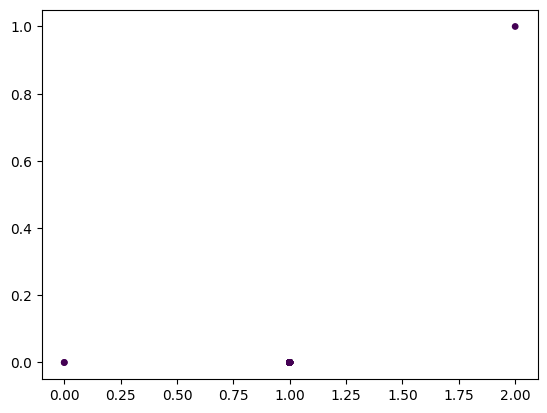

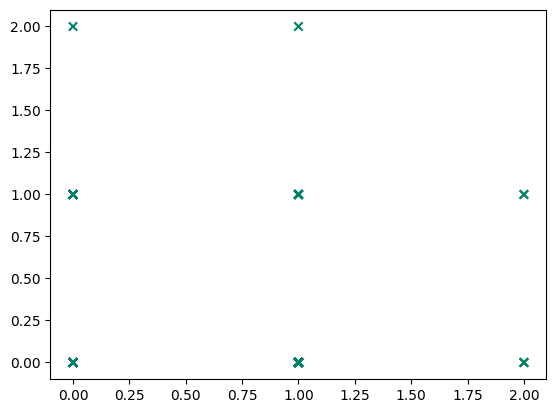

In [2088]:
def createFeatures(trainSeqs:list, num_sample=100):
    """
    Crrer deux features pour chaque séquence: x1 = nombre de AG et x2 = nombre de TA 
    entrée trainSeqs : list de séquences 
    entrée num_sample : nombre d'échantillons 
    sortie X : numpy array contenant deux feature pour chaque séquence
    """
    dim = (num_sample, 2)
    X = np.zeros(dim)
    for i in range(num_sample):
        X[i][0] = trainSeqs[i].count("AG")
        X[i][1] = trainSeqs[i].count("TA")
    return X


Xpos = createFeatures(pos)
Xneg = createFeatures(neg)
print(Xpos)
print(Xneg)


yPos = np.ones(num_sample)
yNeg = np.zeros(num_sample)

#Ploter les données

plt.scatter(Xpos[:,0], Xpos[:, 1], c=yPos, s=15)
plt.show()

plt.scatter(Xneg[:,0], Xneg[:, 1], c=yNeg, marker='x', cmap='summer')
plt.show()







#Normaliser les données entre 0 et 1
X = np.vstack((Xpos, Xneg))

x_norm = (X-np.min(X))/(np.max(X)-np.min(X))

X = x_norm

## 2. Construction d'un neurone artificiel
2.1 Faire une fonction pour initialiser avec des valeurs aléatoires la matrice W et b

In [2089]:
def initialisation(X):
    """
    Initialiser avec des valeurs aléatoires la matrice W et b
    entrée X: matrice de features
    sortie W: matrice de poids du reseau
    sortie b: bias
    """
    top = len(X[0])
    #W = np.random.randn(X.shape[1],1)
    W = np.zeros(top)
    for i in range(top):
        W[i] = random.random()
    W = W.reshape(W.shape[0], 1)
    b = np.random.randn(1)
    return (W, b)
print(X.shape)
W, b = initialisation(X)
print(W)
print(W.shape, b.shape)

(200, 2)
[[0.21557847]
 [0.92741816]]
(2, 1) (1,)


2.2 Faire une fonction qui calcule la fonction d'ativation du neurone 

In [2090]:
def model(X, W, b):
    """
    Calcule Z puis A
    entrée X: matrice de features
    entrée W: matrice de poids du reseau
    entrée b: bias
    sortie A: valeur de la fonction d'ativation
    """

    Z = X.dot(W) + b
    A = 1/(1 + np.exp(-Z))
    
    return A

A = model(X, W, b)

2.2 Faire la fonction logLoss

In [2091]:
def log_loss(A, y):
    """
    Calcule log_loss basée en A et y
    entrée A: vecteur contenant les valeurs de fonctions d'activation pour les num_sample*2
    entrée y: vecteur de labels
    sortie ll: logLoss
    """
    return 1 / len(y) * np.sum(-y * np.log(A) - (1 - y) * np.log(1 - A))



2.3 Faire la fonction qui calcule les gradients

In [2092]:
def gradients(A, X, y):
    """
    Calcule les gradients dW et db
    entrée A: vecteur contenant les valeurs de fonctions d'activation pour num_sample*2
    entrée X: matrice de features
    entrée y: vecteur de labels
    sortie dW: les gradients de W
    sortie db: le gradients de b
    """
    dW = 1 / len(y) * np.dot(X.T, A - y)
    db = 1 / len(y) * np.sum(A - y)

    return (dW, db)

2.4 Faire la fonction pour mettre à jours les parametre W et b

In [2093]:
def update(dW, db, W, b, learning_rate):
    """
    Mettre à jour W et b
    entrée dW: les gradients de W
    entrée db: le gradient de b
    entrée W: matrice de poids W
    entrée b: bias
    entrée learning_rate: pas d'aprentissage
    sortie W: W mis à jour
    sortie b: b mis à jour
    """
    W = W - learning_rate * dW
    b = b - learning_rate * db
   
    return (W, b)

2.5 Faire la fonction pour entraîner un neurone artificiel

In [2094]:
def backPropagation(X, y, learning_rate = 0.08, n_iter = 30):
    """
    Implemente l'algorithme backpropagation
    entrée X: matrice de features
    entrée y: vecteur de labels
    entrée learning_rate: pas d'aprentissage
    entrée n_iter: nombre d'iteration ou epoch
    sortie W: W à la fin de l'entrainement 
    sortie b: b à la fin de l'entrainement 
    sortie Loss: List contenant les valeur de la fonction logLoss à chaque iteration
    """ 
    # initialisation W, b
    W, b = initialisation(X)

    Loss = []

    for i in range(n_iter):
        A = model(X, W, b)
        Loss.append(log_loss(A, y))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)


    return (W, b, Loss)
nb_iter = 2000
W, b, Loss = backPropagation(X, y, 0.9, nb_iter)
print (X.shape)

(200, 2)


2.6 Ploter les valeurs de LogLoss pour voir si ça diminue au cours des epochs

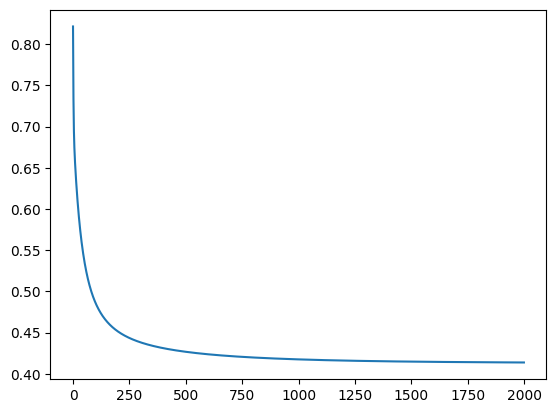

In [2095]:
plt.plot(Loss)
plt.show()

2.7 Faire une fonction Predict qui renvoie 1 si la probabilité donnée par le model est supérieure ou égale à 0.5, 0 sinon

In [2096]:
def predict(X, W, b):
    """
    Predire le label de donnees X en ulisant parametre W, b
    entrée X: matrice de features
    entrée W: matrice de poids W
    entrée b: bias
    sortie A: 1 si la probalité donnee par le model est superieur ou egale à 0.5, 0 sinon 
    """ 
    A = 0
    A = model(X, W, b)
    return A >= 0.5

2.8 Afficher l'accuracy du model sur les données d'entrainement.

In [2097]:
from sklearn.metrics import accuracy_score

y_pred = predict(X, W, b)
#print(y_pred,y)
print(accuracy_score(y, y_pred))

0.86


## 3. Amelioration du modèle

3.1 Quel est la performance du modèle? Changer les paramètres learning_rate et n_iter pour améliorer la performance. Comment ces deux paramètres influencent la accuracy?

L'accuracy du modèle est bonne, elle est de 0,9, plus le nombre d'itération est élevé, plus nous sommes précis, le learning_rate impacte la courbe et le nombre d'itération, lui impact la raideur de la courbe, plus tout ces éléments sont élevés, plus les résultats obtenys seront précis. 

3.2 Ajouter d'autre features comme par exemple d'autre dinucléotides, ou trinucleotides et réentraîner le modèle. 

In [2098]:
def createFeatures(trainSeqs:list, num_sample=100):
  """
  Create plusieurs features pour représenter le motif
  entrée trainSeqs : list de séquences d'entrainement
  entrée num_sample : nombre d'échantillons 
  sortie X : numpy array contenant plusieurs features pour chaque séquence
  """
  dim = (num_sample, 8)
  X = np.zeros(dim)
  for i in range(num_sample):
      
      X[i][0] = trainSeqs[i].count("AG")
      X[i][1] = trainSeqs[i].count("TA")
      X[i][2] = trainSeqs[i].count("CG")
      X[i][3] = trainSeqs[i].count("GC")
      X[i][4] = trainSeqs[i].count("CGA")
      X[i][5] = trainSeqs[i].count("ACG")
      X[i][6] = trainSeqs[i].count("ATG")
      X[i][7] = trainSeqs[i].count("GTA")
      
  return X

Xpos = createFeatures(pos)
Xneg = createFeatures(neg)
X = np.vstack((Xpos, Xneg))

x_norm = (X-np.min(X))/(np.max(X)-np.min(X))

X = x_norm
print(X.shape)

(200, 8)


3.3 Réentraîner le modèle et comparer les performances.

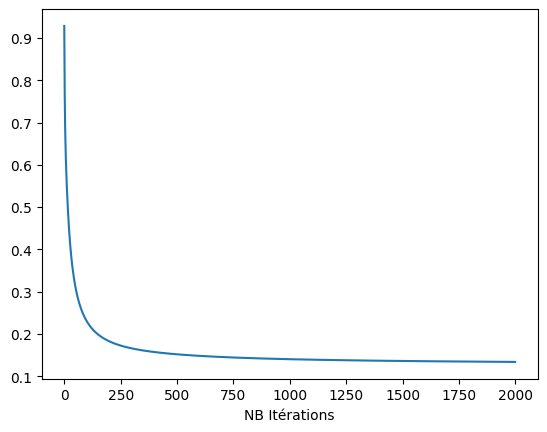

In [2099]:
W, b, Loss = backPropagation(X, y, 0.9, nb_iter)

plt.plot(Loss)
plt.xlabel("NB Itérations")
plt.show()

#En étudiant plus de paramétre on remarque que la courbe est plus précise, et ainsi rend notre analyse plus pertinente 

## 4. Tester sur vous données de chip-seq
4.1 Vous avez peut-être une idée du motif caché dans vos données.
Entraîner un modèle spécifique pour reconnaître le motif d'intérêt.
Telechargé la matrice de frequence du motif d'intérêt sur le site https://jaspar.genereg.net/, chercher par le nom du motif, puis copie sa matrice de frequence. Voici un exemple pour le motif AFT1

In [2100]:
#>HAP5
#freq = np.array([
#[641, 200, 113, 826, 1817, 127, 98, 0, 537, 4156, 0, 0, 387, 361, 0],
#[935, 1914, 1513, 1137, 1451, 637, 3199, 700, 1308, 0, 0, 0, 0, 497, 1730],
#[1033, 2108, 2485, 2155, 440, 1273, 677, 0, 1904, 0, 0, 234, 3788, 3123, 0],
#[1789, 97, 433, 453, 1002, 2389, 624, 3713, 793, 0, 4156, 3922, 0, 262, 2808]
#])

#>Mac1
#freq = np.array([
#[108, 89, 0, 115, 0, 0, 0, 958],
#[0, 0, 0, 0, 1714, 0, 1714, 0],
#[0, 219, 0, 1599, 0, 0, 0, 655],
#[1632, 1451, 1714, 0, 0, 1714, 0, 113]
#])

#>Aft1
#freq = np.array([
#[106, 155, 362, 179, 426, 136, 716, 145, 34, 160, 10, 961, 8, 25, 19, 181, 265, 287, 276, 123, 154],
#[205, 249, 197, 396, 231, 78, 25, 31, 47, 10, 966, 9, 972, 955, 740, 257, 252, 155, 180, 225, 236],
#[231, 220, 221, 222, 154, 142, 31, 288, 39, 812, 11, 15, 9, 2, 13, 494, 241, 183, 68, 357, 458],
#[456, 374, 218, 200, 187, 641, 226, 535, 878, 16, 10, 14, 10, 16, 225, 65, 240, 373, 474, 292, 150]
#])

#>Pdr1
#freq = np.array([
#[8, 0, 0, 13, 2, 8, 10, 62],
#[28, 100, 100, 0, 88, 2, 3, 8],
#[15, 0, 0, 87, 8, 88, 83, 22],
#[48, 0, 0, 0, 2, 2, 3, 8]
#])

#>ATM1
#freq = np.array([
#[327, 369, 198, 140, 180, 160, 596, 598, 0, 54, 86, 367, 407, 206, 139],
#[82, 53, 249, 261, 120, 51, 2, 0, 600, 424, 4, 43, 72, 112, 181],
#[86, 70, 47, 44, 188, 47, 1, 2, 0, 49, 510, 27, 2, 22, 68],
#[105, 108, 106, 155, 112, 342, 1, 0, 0, 73, 0, 163, 119, 260, 212]
#])

#>zap
freq = np.array([
[169, 0, 0, 0, 0, 107, 169, 119, 0, 0, 0, 21, 119, 9, 46],
[0, 279, 279, 97, 0, 77, 0, 17, 0, 0, 0, 97, 0, 17, 0],
[0, 0, 0, 0, 0, 17, 0, 57, 279, 279, 0, 37, 57, 0, 198],
[0, 0, 0, 107, 169, 0, 0, 0, 0, 0, 169, 58, 9, 145, 0]
])

PWM = freq / freq.sum(axis = 0)
motif_length = 10 # à remplacer par taille de la matrice du motif d'interet
num_sample = 100



posTest, negTest  = createArtSequences(PWM, num_sample)



4.2 Recoder la fonction ``createFeatures`` pour créer un ensemble de features qui représentent bien le motif d'intérêt. Vous  pouvez utiliser autant de features qui vous souhaitez.

In [2101]:
#def createFeatures(trainSeqs:list, num_sample=100):
#  """
#  Create plusieurs features pour représenter le motif
#  entrée trainSeqs : list de séquences d'entrainement
#  entrée num_sample : nombre d'échantillons 
#  sortie X : numpy array contenant plusieurs features pour chaque séquence
#  """
#  dim = (num_sample, 8)
#  X = np.zeros(dim)
#  for i in range(num_sample):  
#    X[i][0] = trainSeqs[i].count("CT")
#    X[i][1] = trainSeqs[i].count("CA")
#    X[i][2] = trainSeqs[i].count("CG")
#    X[i][3] = trainSeqs[i].count("TT")
#    X[i][4] = trainSeqs[i].count("GG")
#    X[i][5] = trainSeqs[i].count("AG")
#    X[i][6] = trainSeqs[i].count("TG")
#    X[i][7] = trainSeqs[i].count("AT")
#  #print(X)
#      
#  return X

def createFeatures(trainSeqs:list, num_sample=100):
  """
  Create plusieurs features pour représenter le motif
  entrée trainSeqs : list de séquences d'entrainement
  entrée num_sample : nombre d'échantillons 
  sortie X : numpy array contenant plusieurs features pour chaque séquence
  """
  dim = (num_sample, 8)
  X = np.zeros(dim)
  for i in range(num_sample):  
    X[i][0] = trainSeqs[i].count("CC")
    X[i][1] = trainSeqs[i].count("TT")
    X[i][2] = trainSeqs[i].count("NA")
    X[i][3] = trainSeqs[i].count("GG")
    X[i][4] = trainSeqs[i].count("GT")
    X[i][5] = trainSeqs[i].count("CCTT")
    X[i][6] = trainSeqs[i].count("NAG")
    X[i][7] = trainSeqs[i].count("GGT")
  #print(X)
      
  return X


In [2102]:
Xpos = createFeatures(pos)
Xneg = createFeatures(neg)
X = np.vstack((Xpos, Xneg))

min_val = np.min(X)
max_val = np.max(X)
if max_val - min_val == 0:
    X_norm = np.zeros(X.shape)
else:
    X_norm = (X - min_val) / (max_val - min_val)


X = x_norm

In [2103]:
yTest = np.concatenate((np.ones(num_sample), np.zeros(num_sample)))
yTest = yTest.reshape((yTest.shape[0], 1))
y.shape

(200, 1)

4.4 Réentraîner le modèle et ajuster les paramètres à fin d'obtenir la meilleure performance.

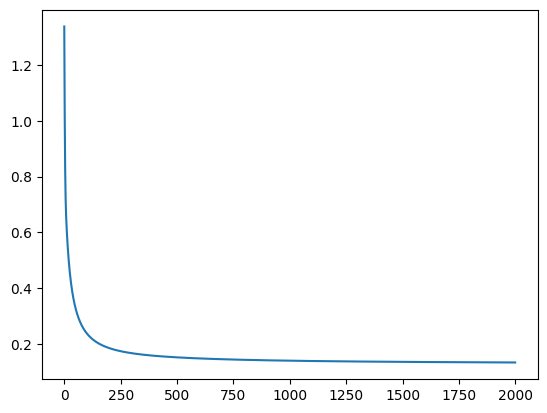

0.86


In [2104]:
W, b, Loss = backPropagation(X, y, 0.9, nb_iter)

plt.plot(Loss)
plt.show()
print(accuracy_score(y, y_pred))


4.5 Lire votre fichier et charger les séquences.

In [2105]:
def readFasta(genome):
    sequence = []
    file = open(genome, "r")
    sequences = []
    seq = ""
    for s in file:
        if s[0] != ">":
            seq += s.strip().upper()
        else:
            sequences.append(seq)
            seq = ""
    return sequences[1:]
genome = "Sequence_by_Peaks_3.fasta"
sequence = readFasta(genome)[0]
print(sequence)

CCGCTCTCCTGCACTCCTCCAGCGCAGCAAGGAACTCCTTGGGGTTGGCACCGGAGAGCTCCTTCAGGATGGTCCCGTTCCTGATCAGCACGAAGTATGGCACCGCGCTTATCTCAAACAGCTCAGCTATCTCAGCCTGCTCGTCCGCATCCACCGCCAAGAACGACACGTCCTTGTTCGACTCGTCTTCGCTTATAGCCCGGTACAACTCGCTGATGGCCTTGCAGGGCTCCGCCCACGAGGTGTGGAAATATATAGCAATCAGCTTGTCCTGCACATTCTGCGTAGTCAGCTCCGTAAACTGGTCCTGGTTCGTAATCTCAGCAACCATATTCCTCTTCAAAAAGTGTCTCCTGCCTTCGATTTCCCTCCTTCCCCCCTCCATTGCCCCCCACCATCACTGCCAGACTCTCAACTGGTCCCTATTTATACTGCCCGATGAGCTCGGATTACAAAGGATTTAGAAGCGATCCCACCGTCGTACAAGATAATGGTAGCTGTGGGGGGGGGGTGTGTCTCGGTCTCAGCCAATCACCGTCGAGTGCATTACTAATCGCCACCATCGACAGCCAACTGTACAGCCCATCGCCACAGCCCATCGCCCCCATCGCCACACTTAGTTGTGTTGTAATTGTATCTGAAGTTGTAGTACTTGTGTTCCTGGTTTGCTGGTTTGCTTGGTTTGTCGGTGTATCTGCAGTTGTGTATTTGCAGGTCTGTGACTTGCACCCAGACATCATGTACTTCCCCCCCCCCCCAAATTCCAAAATTCCAATACAAATCCTCTTCTCCTGCGGAATCTCCTATTTAGGAAATCTTGGTGTTTCTGCATTTGCAAGTGTATCCCTTGGTACGTGTTCATGTGTATCCCGTGTATCAGTACCTTGATTCCCTCCCCCCCATCGAAAATGCAAAAAAAAATTTTTTAGCGAAATAAAAAGGGCATCGCTGCCTTGTTAGCTATTGCTAGCTATTGCTAGTTTCCTTGTCGTTGTTATAT

4.6 Faire une fonction pour parcourir votre séquence et conter combien de fois le modèle prédire le motif, exprimer en pourcentage.

In [2106]:
def seqToMatrix(sequence, motif_length):
    n = len(sequence) - motif_length + 1
    matrix = np.zeros((n, motif_length))
    for i in range(n):
        sub_seq = sequence[i:i+motif_length]
        for nucleotide in sub_seq:
            if nucleotide == 'A':
                matrix[i, 0] += 1
            elif nucleotide == 'C':
                matrix[i, 1] += 1
            elif nucleotide == 'G':
                matrix[i, 2] += 1
            elif nucleotide == 'T':
                matrix[i, 3] += 1

    return matrix

def predireMotif(sequence, motif_length, W, b):
    """
    Prédire les positions des motifs et calculer le pourcentage d'apparition du motif.
    entrée sequence : sequence de nucleotides 
    entrée motif_length : taille du motif
    entrée W: matrice de poids W
    entrée b: bias
    sortie perc : pourcentage d'aparission du motif

    """
    countMotif = 0
    countTotal = len(sequence) - motif_length + 1
    #print(countTotal)
    motifs = []
    for i in range (countTotal) :
        motif = sequence[i : i + motif_length]
        motifs.append(motif)
    feat = createFeatures(motifs, countTotal)
    #print(feat)
    pred = predict(feat, W, b)
    #print(pred)
    mod = model(feat, W, b)
    #print(mod)
    for j in range(countTotal):
        if(pred[j]):
            countMotif += 1
            #print(motifs[j], mod[j])
    
    return countMotif / countTotal

sequence = "CCGCTCTCCTGCACTCCTCCAGCGCAGCAAGGAACTCCTTGGGGTTGGCACCGGAGAGCTCCTTCAGGATGGTCCCGTTCCTGATCAGCACGAAGTATGGCACCGCGCTTATCTCAAACAGCTCAGCTATCTCAGCCTGCTCGTCCGCATCCACCGCCAAGAACGACACGTCCTTGTTCGACTCGTCTTCGCTTATAGCCCGGTACAACTCGCTGATGGCCTTGCAGGGCTCCGCCCACGAGGTGTGGAAATATATAGCAATCAGCTTGTCCTGCACATTCTGCGTAGTCAGCTCCGTAAACTGGTCCTGGTTCGTAATCTCAGCAACCATATTCCTCTTCAAAAAGTGTCTCCTGCCTTCGATTTCCCTCCTTCCCCCCTCCATTGCCCCCCACCATCACTGCCAGACTCTCAACTGGTCCCTATTTATACTGCCCGATGAGCTCGGATTACAAAGGATTTAGAAGCGATCCCACCGTCGTACAAGATAATGGTAGCTGTGGGGGGGGGGTGTGTCTCGGTCTCAGCCAATCACCGTCGAGTGCATTACTAATCGCCACCATCGACAGCCAACTGTACAGCCCATCGCCACAGCCCATCGCCCCCATCGCCACACTTAGTTGTGTTGTAATTGTATCTGAAGTTGTAGTACTTGTGTTCCTGGTTTGCTGGTTTGCTTGGTTTGTCGGTGTATCTGCAGTTGTGTATTTGCAGGTCTGTGACTTGCACCCAGACATCATGTACTTCCCCCCCCCCCCAAATTCCAAAATTCCAATACAAATCCTCTTCTCCTGCGGAATCTCCTATTTAGGAAATCTTGGTGTTTCTGCATTTGCAAGTGTATCCCTTGGTACGTGTTCATGTGTATCCCGTGTATCAGTACCTTGATTCCCTCCCCCCCATCGAAAATGCAAAAAAAAATTTTTTAGCGAAATAAAAAGGGCATCGCTGCCTTGTTAGCTATTGCTAGCTATTGCTAGTTTCCTTGTCGTTGTTATATAAAAAGAACCACGGATTAAATATCTTTATTTGGTGAGTAAGACGCATTTAT"
percMotif = predireMotif(sequence, motif_length, W, b)
print(percMotif)

0.23563218390804597


4.7 Pour contrôler que le pourcentage d'apparition du motif d'intérêt et pas du au hasard, entraîner un modèle avec un autre motif et vérifier si le pourcentage du motif d'intérêt est supérieur.

In [2107]:
#sequence = 'ACGTACGTACGTACGT'
sequence = "CCGCTCTCCTGCACTCCTCCAGCGCAGCAAGGAACTCCTTGGGGTTGGCACCGGAGAGCTCCTTCAGGATGGTCCCGTTCCTGATCAGCACGAAGTATGGCACCGCGCTTATCTCAAACAGCTCAGCTATCTCAGCCTGCTCGTCCGCATCCACCGCCAAGAACGACACGTCCTTGTTCGACTCGTCTTCGCTTATAGCCCGGTACAACTCGCTGATGGCCTTGCAGGGCTCCGCCCACGAGGTGTGGAAATATATAGCAATCAGCTTGTCCTGCACATTCTGCGTAGTCAGCTCCGTAAACTGGTCCTGGTTCGTAATCTCAGCAACCATATTCCTCTTCAAAAAGTGTCTCCTGCCTTCGATTTCCCTCCTTCCCCCCTCCATTGCCCCCCACCATCACTGCCAGACTCTCAACTGGTCCCTATTTATACTGCCCGATGAGCTCGGATTACAAAGGATTTAGAAGCGATCCCACCGTCGTACAAGATAATGGTAGCTGTGGGGGGGGGGTGTGTCTCGGTCTCAGCCAATCACCGTCGAGTGCATTACTAATCGCCACCATCGACAGCCAACTGTACAGCCCATCGCCACAGCCCATCGCCCCCATCGCCACACTTAGTTGTGTTGTAATTGTATCTGAAGTTGTAGTACTTGTGTTCCTGGTTTGCTGGTTTGCTTGGTTTGTCGGTGTATCTGCAGTTGTGTATTTGCAGGTCTGTGACTTGCACCCAGACATCATGTACTTCCCCCCCCCCCCAAATTCCAAAATTCCAATACAAATCCTCTTCTCCTGCGGAATCTCCTATTTAGGAAATCTTGGTGTTTCTGCATTTGCAAGTGTATCCCTTGGTACGTGTTCATGTGTATCCCGTGTATCAGTACCTTGATTCCCTCCCCCCCATCGAAAATGCAAAAAAAAATTTTTTAGCGAAATAAAAAGGGCATCGCTGCCTTGTTAGCTATTGCTAGCTATTGCTAGTTTCCTTGTCGTTGTTATATAAAAAGAACCACGGATTAAATATCTTTATTTGGTGAGTAAGACGCATTTAT"
motif_length = 8
W = np.array([[0.11060712], [-0.00053392], [0.00278149], [0.91824518], [0.72824011], [-0.00256310], [0.92280085], [0.11111111]])
b = np.array([-0.06332915])
percMotif = predireMotif(sequence, motif_length, W, b)
print(percMotif)


0.43007662835249044
